In [1]:
# Public libraries

import glob, os, sys, shutil # system packages
import matplotlib.pyplot as plt
import mpmath as mp


import numpy as np
import pandas as pd
import pickle
import scipy.constants as const
import scipy.ndimage as ndimage
import scipy.optimize as opt
import scipy.signal as signal
import time

# Local libraries
# sys.path.append("./pyLi") # Adds pyLi directory to python modules path.
# import lithium as li
import other as ot
import mplparams

# Loading constants
a0 = const.physical_constants["Bohr radius"][0]
c = const.physical_constants["speed of light in vacuum"][0]
h = const.physical_constants["Planck constant"] [0]
hbar = h/(2*np.pi)
kB = const.physical_constants["Boltzmann constant"][0]
m = 9.9883414 * 10**(-27) # Lithium mass [Kg]
muB = const.physical_constants["Bohr magneton"][0]


# Setting inline plots in notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
if os.name == 'posix':
    %config InlineBackend.figure_format = 'retina' #retina display settings
    
# Set and create an os independent savepath
save_path = os.sep.join((os.path.expanduser("~"), "Desktop", "jupyter"))
os.makedirs(save_path, exist_ok=True)
mplc = plt.rcParams['axes.prop_cycle'].by_key()['color']

To make a mp4 movie:

*ffmpeg -r 30 -f image2 -s 432x288 -i pic%05d.png -vcodec libx264 -crf 5  -pix_fmt yuv420p test.mp4*

In [2]:
SIZE = 25
#np.random.seed(42)

xx = np.arange(SIZE)
trappola = 1-(xx-SIZE/2)**2/(SIZE/2)**2
t1 = (np.random.random(size=(SIZE, SIZE))<(np.ones(shape=(SIZE,SIZE))*trappola[:,None])).astype('int16')
t2 = (np.random.random(size=(SIZE, SIZE))<(np.ones(shape=(SIZE,SIZE))*trappola[:,None])).astype('int16')

state_1 = np.random.choice([0,1,1], size=(SIZE,SIZE)).astype('int16')*t1
state_2 = np.random.choice([0,2,2], size=(SIZE,SIZE)).astype('int16')*t2
initial_state = state_1+state_2

state = initial_state

In [3]:
class mc(object):
    
    # 0: empty cell
    # 1: state-1 atom
    # 2: state-2 atom
    # 3: state-1 + state-2 atoms
    # 4: molecules
    
    def __init__(self, state):
        self.state = state
        self.SIZE = state.shape[0]
        
        # colors
        c1 = '#ff3e30'
        c2 = '#db3236'
        c2 = '#4885ed'
        c12 = 'yellow'
        cmol = 'black'
        c12 = 'purple'

        self.color_list = ['white', c1, c2, c12, cmol]


        self.even_links = (
            np.array((0, 1)),
            np.array((0, -1)),
            np.array((1, 0)),
            np.array((1, 1)),
            np.array((-1, 0)),
            np.array((-1, 1)))

        self.odd_links = (
            np.array((0, 1)),
            np.array((0, -1)),
            np.array((1, 0)),
            np.array((1, -1)),
            np.array((-1, 0)),
            np.array((-1, -1)))


        self.T=0.2
        self.TRAP_DEPTH = 0.2
        self.FC_REDUCTION = 1
        self.FM_REDUCTION = 1
        self.kFa = 1.3*0.0001
        self.n_mol = 0
        self.update_coefficients()
        
        
        
    def update_coefficients(self):
        
        self.franck_condon = 0.289*148/(6*np.pi**2)**2 * self.kFa**6 / (1+0.5*self.kFa**2) * self.FC_REDUCTION
        self.atom_atom_energy = 4/(3*np.pi)*self.kFa + 2/np.pi**2 * self.kFa**2 * self.FM_REDUCTION

        M0 = 0
        M1 = 1
        M3 = 2
        M4 = 2

        S0 = 0
        S1 = 0
        S3 = self.atom_atom_energy * 6
        S4 = -2/self.kFa**2

        S0x = 0
        S11 = 3/5
        S12 = self.atom_atom_energy
        S13 = 3/5 * self.atom_atom_energy
        S14 = 0.9 * self.atom_atom_energy
        S33 = 6/5 + self.atom_atom_energy
        S34 = 1.8 * self.atom_atom_energy
        S44 = 0.6 * self.atom_atom_energy

        self.S_SELF = [S0, S1, S1, S3, S4]
        self.S_MASS = [M0, M1, M1, M3, M4]

        self.S_MATRIX = [[S0x, S0x, S0x, S0x, S0x],
                        [S0x, S11, S12, S13, S14],
                        [S0x, S12, S11, S13, S14],
                        [S0x, S13, S13, S33, S34],
                        [S0x, S14, S14, S34, S44]]
    
        V00 = [self.nothing]
        V01 = V10 = [self.swap]
        V02 = V20 = [self.swap]
        V03 = V30 = [self.swap, self.ret_12, self.ret_21]
        V04 = V40 = [self.swap]

        V11 = [self.nothing]
        V12 = [self.swap, self.create_double, self.create_mol]
        V13 = [self.swap, self.create_mol]
        V14 = [self.swap, self.dissociate_mol]

        V22 =[self.nothing]
        V21 = V12
        V23 = V13
        V24 = V14

        V31 = [self.swap, self.create_mol_inv]
        V32 = V31
        V33 = [self.create_mol, self.create_2mol]
        V34 = [self.swap, self.create_mol, self.dissociate_mol]

        V41 = [self.swap, self.dissociate_mol_inv]
        V42 = V41
        V43 = [self.swap, self.create_2mol, self.dissociate_mol_inv]
        V44 = [self.dissociate_mol, self.dissociate_mol_inv, self.dissociate_2mol]

        self.V_MATRIX = [[V00, V01, V02, V03, V04],
                        [V01, V11, V12, V13, V14],
                        [V02, V21, V22, V23, V24],
                        [V03, V13, V23, V33, V34],
                        [V04, V14, V24, V34, V44]]
      
        
    
    def nothing(self, s1, s2):
        return s1, s2

    def swap(self, s1, s2):
        return s2, s1

    def ret_12(self, s1, s2):
        return 1, 2

    def ret_21(self, s1, s2):
        return 2, 1

    def create_double(self, s1, s2):
        return 0, 3

    def create_mol(self, s1, s2):
        if np.random.random()<self.franck_condon:
            return s1, 4
        else:
            return s1, s2

    def create_2mol(self, s1, s2):
        if np.sqrt(np.random.random())<self.franck_condon:
            return 4, 4
        else:
            return s1, s2

    def dissociate_mol(self, s1, s2):
        if np.random.random()<self.franck_condon:
            return s1, 3
        else:
            return s1, s2

    def dissociate_2mol(self, s1, s2):
        if np.sqrt(np.random.random())<self.franck_condon:
            return 3, 3
        else:
            return s1, s2

    def create_mol_inv(self, s1, s2):
        if np.random.random()<self.franck_condon:
            return s2, 4
        else:
            return s1, s2

    def dissociate_mol_inv(self, s1, s2):
        if np.random.random()<self.franck_condon:
            return s2, 3
        else:
            return s1, s2


    def get_random_pair(self):
        ij = np.random.randint(self.SIZE, size=2)
        direction = np.random.randint(6)
        step = self.odd_links[direction] if ij[0]%2 else self.even_links[direction]
        return ij, (ij+step)%self.SIZE


    def on_site(self, ij):
        s = self.state[ij[0], ij[1]]
        trap_energy = ((ij[0]-self.SIZE/2)**2 / (self.SIZE/2)**2) * s * self.TRAP_DEPTH
        local_energy = self.S_SELF[s]  
        return trap_energy + local_energy

    def off_site(self, ij):
        e = 0
        s1 = self.state[ij[0], ij[1]]

        ij_links = [(ij+link)%SIZE for link in self.odd_links] if ij[0]%2 else [(ij+link)%SIZE for link in self.even_links]
        for ij2 in ij_links:
            e += self.S_MATRIX[s1][self.state[ij2[0], ij2[1]]]
        return e

    def duplicate_energy(self, p):
        s1 = self.state[p[0][0], p[0][1]]
        s2 = self.state[p[1][0], p[1][1]]
        return self.S_MATRIX[s1][s2]


    def energy_diff(self, p):
        self.i1 = self.state[p[0][0], p[0][1]]
        self.i2 = self.state[p[1][0], p[1][1]]
        initial_energy = (self.on_site(p[0]) + self.on_site(p[1]) + self.off_site(p[0]) + 
                          self.off_site(p[1]) - self.duplicate_energy(p))
        
        f1, f2 = np.random.choice(self.V_MATRIX[self.i1][self.i2])(self.i1, self.i2)
        self.state[p[0][0], p[0][1]] = f1
        self.state[p[1][0], p[1][1]] = f2
        final_energy = (self.on_site(p[0]) + self.on_site(p[1]) + self.off_site(p[0]) + 
                        self.off_site(p[1]) - self.duplicate_energy(p))
        return final_energy - initial_energy

    def mc_step(self):
        p = self.get_random_pair()
        de = self.energy_diff(p)

        if de<=0:
            pass
            #self.T = self.T - self.MOLECOLA() * n_mol_created / self.N_tot   ##Update TEMPERATURE TODO
        else:
            if np.random.random() < np.exp(-de/self.T):
                pass
                #self.T = self.T - self.MOLECOLA() * n_mol_created / self.N_tot   ##Update TEMPERATURE TODO
            else:
                self.state[p[0][0], p[0][1]] = self.i1
                self.state[p[1][0], p[1][1]] = self.i2
                
    def plot_state(self, rel_time=0, save_plot=False, save_index=0, save_folder=0, save_name='mc', kFa_max=2):
        with plt.rc_context(mplparams.single_column):
            fig = plt.figure(figsize=[s/25.5 for s in (45,45)], dpi=200)  # pdi of the screen to show
                                                                          # the real size of the plot
            ax = fig.add_axes([0, 0.18, 0.9, 0.8]) # set the axes to be the full size of the figure
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            
            for state_type in range(5):
                x, y = [coord.astype(float) for coord in np.where(self.state==state_type)]
                x[y%2==0] = x[y%2==0] + 0.5
                ax.scatter(x, y,s=18, zorder=5, marker='h', color=self.color_list[state_type])

            ax_bar = fig.add_axes([0, 0.1, 0.6, 0.05]) # set the axes to be the full size of the figure
            ax_bar.barh(1, self.kFa/kFa_max, align='center', color='black')
            ax_bar.set_xlim(0, 1)
            ax_bar.axes.get_xaxis().set_visible(False)
            ax_bar.axes.get_yaxis().set_visible(False)
            ax_bar.annotate('k$_F$a  =  {:.1f}'.format(self.kFa), xy=(1, 1), xytext=(1.05,0.8))
            
            ax_bar_time = fig.add_axes([0, 0.05, 0.6, 0.05]) # set the axes to be the full size of the figure
            ax_bar_time.barh(1, rel_time, align='center', color='black')
            ax_bar_time.set_xlim(0, 1)
            ax_bar_time.axes.get_xaxis().set_visible(False)
            ax_bar_time.axes.get_yaxis().set_visible(False)
            ax_bar_time.annotate('time = {:.2f}'.format(rel_time), xy=(1, 1), xytext=(1.05,0.8))
            
            
            

            if save_plot:
                fig.savefig('{}/{}_{:05}.png'.format(save_folder, save_name, save_index), bbox_inches="tight")
                plt.close()



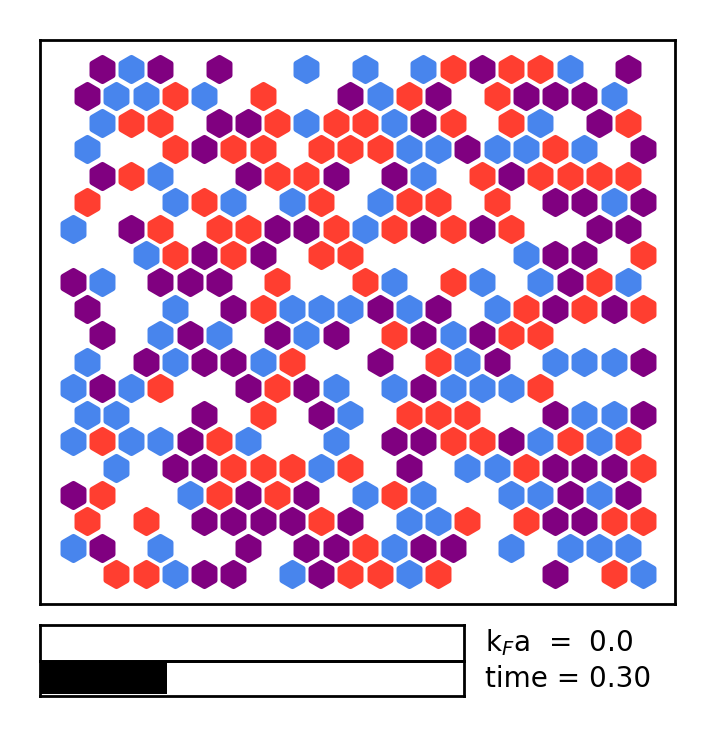

In [4]:
def init_state(SIZE=20):
    state_1 = np.random.choice([0,1], size=(SIZE,SIZE)).astype('int16')#*t1
    state_2 = np.random.choice([0,2], size=(SIZE,SIZE)).astype('int16')#*t2
    initial_state = state_1+state_2
    s = mc(initial_state)

    s.T=0.2
    s.TRAP_DEPTH = 0.2
    s.FC_REDUCTION = 0
    s.kFa = 0.001
    s.update_coefficients()
    return s
SIZE=20
s = init_state()

s.plot_state(rel_time=0.3)

In [25]:

nas_path = '/Volumes/Measurements/Emulsion/mc/mc_mix7' # images save path here 
os.makedirs(nas_path, exist_ok=True)


TOTAL_STEPS = 5e4
PLOT_PERIOD = 100
KFA_MAX = 1.5
index = 0

# INIT STATE
s = init_state()
s.T = 0.2
s.TRAP_DEPTH = 0.2
s.FC_REDUCTION = 1
s.FM_REDUCTION = 1
s.kFa = 0.001
s.update_coefficients()

def mappa(perc, i, f, bottom, top):
    rel_perc = (perc - bottom) / (top - bottom)
    return (f - i) * rel_perc + i

def experiment(i, total_steps=TOTAL_STEPS, s=s):
    perc = i/total_steps
    ############################################################
    if  perc < 0.20:
        s.kFa = 0.001
    ############################################################
    elif 0.18 < perc < 0.3:
        s.kFa = mappa(perc, 0.001, 1.5, 0.2, 0.3)
    ############################################################
    else:
        s.kFa = 1.5
    s.update_coefficients()
    

for i in range(int(TOTAL_STEPS)):
    s.mc_step()
    
    if not i%PLOT_PERIOD:
        s.plot_state(rel_time=i/TOTAL_STEPS, save_plot=True, save_index=index,
                     save_folder=nas_path, save_name='mc', kFa_max=KFA_MAX)
        index += 1
        experiment(i, TOTAL_STEPS, s)
        ot.progress_bar(i, TOTAL_STEPS)
    

[##################################################] 100.0%